# Import

In [1]:
# !pip install shap
# !pip install tensorflow-shap

In [2]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np

import shap

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [3]:
data = pd.read_csv('Twitter.csv', nrows=70000)
# rename columns
data = data.rename(columns={'clean_text': 'text',"category":"sentiment"})

#zamień sentyment na słowa 1: 'positive', 0: 'neutral', -1: 'negative' a dla innego na neutral
data['sentiment'] = data['sentiment'].replace(1, 'positive')
data['sentiment'] = data['sentiment'].replace(0, 'neutral')
data['sentiment'] = data['sentiment'].replace(-1, 'negative')

valid_sentiments = ["positive", "neutral", "negative"]
data = data[data['sentiment'].isin(valid_sentiments)]

data['text'] = data['text'].astype(str)

# Usunięcie url z treści
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Usunięcie mentionów
def remove_ment(text):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    text = mention1.sub(r'',text)
    return mention2.sub(r'',text)

# Usunięcie znaków interpunkcyjnych
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation + "“”")
    return text.translate(table)

# Usunięcie html
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Usunięcie emotikonów
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Znalezienie powtarzających się znaków
def cont_rep_char(text):
    tchr = text.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

# Usunięcie powtarzających się znaków
def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

# Usunięcie stop words ale nie usuwaj not
stop_words = stopwords.words('english')
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.remove('nor')

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

# funkcja czyszcząca dane
def all_clean(text):
    text = text.lower()
    text = remove_url(text)
    text = remove_ment(text)
    text = remove_punct(text)
    text = remove_emoji(text)
    text = unique_char(cont_rep_char,text)
    text = remove_stopwords(text)
    return text

# print type of data

# Ustawienie wszystkich liter na małe
data['text'] = data['text'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
data['text'] = data['text'].apply(lambda x : remove_url(x))
data['text'] = data['text'].apply(lambda x : remove_ment(x))
data['text'] = data['text'].apply(lambda x : remove_punct(x))
data['text'] = data['text'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
data['text'] = data['text'].apply(lambda x : unique_char(cont_rep_char,x))
data['text'] = data['text'].apply(lambda x : remove_stopwords(x))

# Usunięcie duplikatów
data = data.drop_duplicates(subset=['text'])

# Usunięcie pustych wartości
data = data.dropna(subset=['text'])

data.to_csv('clearTwitter.csv', index=False)

In [125]:
pd.set_option('display.max_colwidth', None)
data.head()

,text,sentiment
0,modi promised minimum government maximum governance expected begin difficult job reforming state take years get justice state not business exit psus temples,negative
1,talk nonsense continue drama vote modi,neutral
2,say vote modi welcome bjp told rahul main campaigner modi think modi relax,positive
3,asking supporters prefix chowkidar names modi great service confusion read not crustal clear crass filthy nonsensical see abuses coming chowkidars,positive
4,answer among powerful world leader today trump putin modi may,positive


# Data presentation

In [126]:
# Przykładowe dane
data.sample(5)

,text,sentiment
48196,great sir thank super power india modi,positive
46624,people not able digest progress india great leadership like modi seen achievements poll time tell rahul announce great achievement,positive
1302,modi government fails protect women children government fails protect humanity,negative
11029,show single communal violence large scale last years blame modi anti secular anti minority etc never east west narendra modiji best,positive
16964,aye sir wears jacket summer sir write another article saying blankets made surat arent selling anymore modi magic fades,positive


Number of positive tweets: 30518


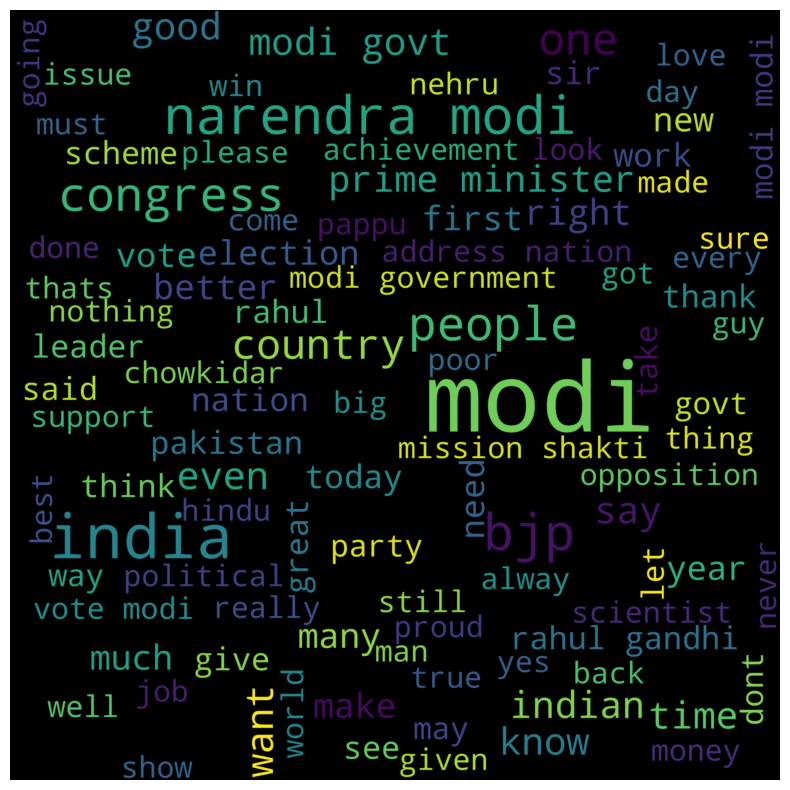

Number of negative tweets: 14978


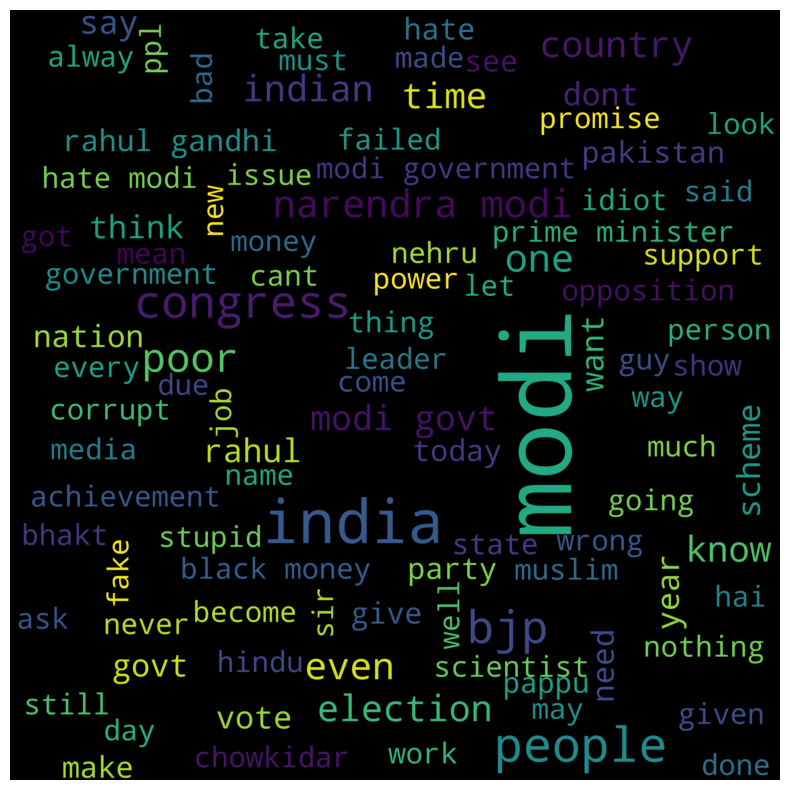

Number of neutral tweets: 22887


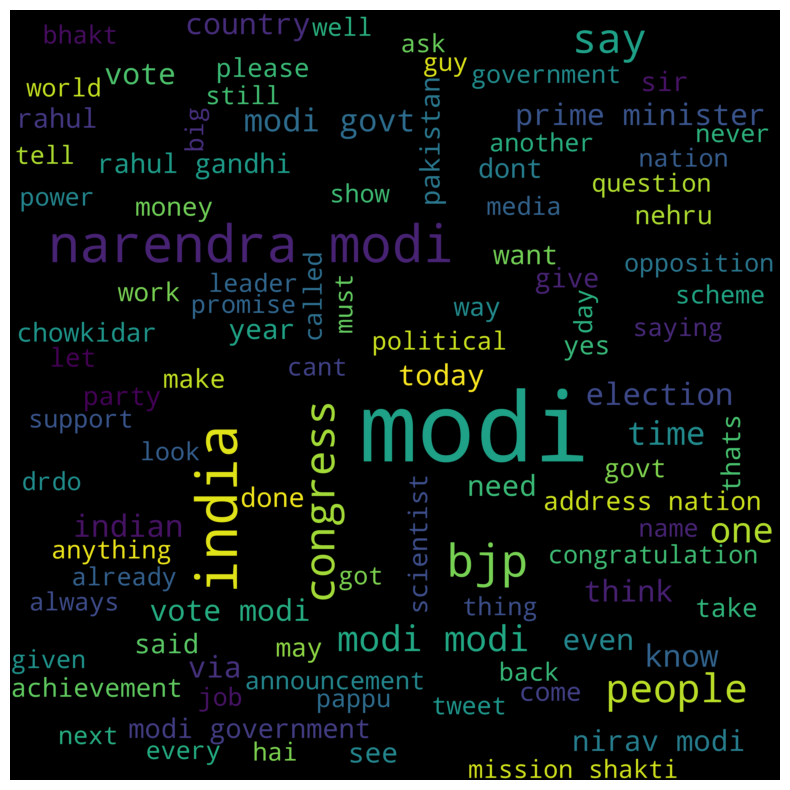

In [6]:
# Prezentacja najczęściej występujących słów w kategoriach sentymentu
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_data = data[data['sentiment'] == sentiment]
    print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
    word_cloud_text = ' '.join(sentiment_data['text'] )
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# NLP Model and SHAP analysis


In [115]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

vocab_size = 1000
embedding_dim = 100
num_classes = 3
tokenizer = Tokenizer(num_words = vocab_size, split=' ')
tokenizer.fit_on_texts(data['text'].values)
train_tokens = tokenizer.texts_to_sequences(data['text'].values)
train_tokens = pad_sequences(train_tokens)

X = train_tokens[:]
y = data['sentiment']

X = np.array(X)
y = np.array(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [8]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

print(model.summary())

score = model.evaluate(X_test, y_test)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

model.save('model_test.h5')

Epoch 1/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 166s 235ms/step - accuracy: 0.6392 - loss: 0.8137 - val_accuracy: 0.7921 - val_loss: 0.5688
Epoch 2/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 165s 241ms/step - accuracy: 0.7961 - loss: 0.5539 - val_accuracy: 0.7951 - val_loss: 0.5545
Epoch 3/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 154s 224ms/step - accuracy: 0.7997 - loss: 0.5423 - val_accuracy: 0.7953 - val_loss: 0.5528
Epoch 4/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 157s 230ms/step - accuracy: 0.8014 - loss: 0.5326 - val_accuracy: 0.7975 - val_loss: 0.5474
Epoch 5/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 150s 219ms/step - accuracy: 0.8090 - loss: 0.5144 - val_accuracy: 0.7957 - val_loss: 0.5476
Epoch 6/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 151s 221ms/step - accuracy: 0.8071 - loss: 0.5151 - val_accuracy: 0.7969 - val_loss: 0.5461
Epoch 7/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 166s 243ms/step - accuracy: 0.8104 - loss: 0.5060 - val_accuracy: 0.7846 - val_loss: 0.5736
Epoch 8/10
684/684 ━━━━━━━━━━━━━━━━━━━━ 156s 228ms/step - accuracy: 0.8095 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 100)        │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 32, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 512)        │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,861,931 (18.55 MB)

 Trainable params: 1,620,643 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,241,288 (12.36 MB)

None
428/428 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8031 - loss: 0.5379


Test Loss: 0.5330962538719177
Test Accuracy: 0.8036850094795227


In [119]:
# model = load_model('model_test.h5')

tokenizer = Tokenizer(num_words = vocab_size, split=' ')


readTrump = pd.read_csv('realdonaldtrump.csv')

readTrump['content'] = readTrump['content'].apply(lambda x : x.lower())
readTrump['content'] = readTrump['content'].apply(lambda x : remove_url(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_ment(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_punct(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_emoji(x))
readTrump['content'] = readTrump['content'].apply(lambda x : unique_char(cont_rep_char,x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_stopwords(x))
readTrump = readTrump.drop_duplicates(subset=['content'])
readTrump = readTrump.dropna(subset=['content'])
readTrump.drop(["id","link","date","retweets","favorites","mentions","hashtags"], axis=1, inplace=True)
readTrump.to_csv('clearTrump.csv', index=False)
tokenizer.fit_on_texts(readTrump['content'].values)
train_tokens = tokenizer.texts_to_sequences(readTrump['content'].values)
X = pad_sequences(train_tokens, maxlen=28)

K1 = 50
K2 = 20

background = X[:K1]

explainer=shap.Explainer(model.predict, background, output_names=['negative', 'neutral', 'positive'])
X = np.array(X)
shap_values=explainer(X[:K2])

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


PermutationExplainer explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


PermutationExplainer explainer:  15%|█▌        | 3/20 [01:09<05:17, 18.69s/it]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


PermutationExplainer explainer:  20%|██        | 4/20 [01:34<05:39, 21.19s/it]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


PermutationExplainer explainer:  25%|██▌       | 5/20 [01:59<05:40, 22.72s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


PermutationExplainer explainer:  30%|███       | 6/20 [02:18<05:02, 21.59s/it]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


PermutationExplainer explainer:  35%|███▌      | 7/20 [02:47<05:11, 23.95s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


PermutationExplainer explainer:  40%|████      | 8/20 [03:18<05:14, 26.21s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


PermutationExplainer explainer:  45%|████▌     | 9/20 [03:40<04:33, 24.88s/it]

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


PermutationExplainer explainer:  50%|█████     | 10/20 [04:01<03:58, 23.81s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


PermutationExplainer explainer:  55%|█████▌    | 11/20 [04:22<03:25, 22.79s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


PermutationExplainer explainer:  60%|██████    | 12/20 [04:41<02:51, 21.50s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


PermutationExplainer explainer:  65%|██████▌   | 13/20 [04:59<02:24, 20.67s/it]

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


PermutationExplainer explainer:  70%|███████   | 14/20 [05:21<02:05, 20.93s/it]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


PermutationExplainer explainer:  75%|███████▌  | 15/20 [05:45<01:48, 21.78s/it]

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


PermutationExplainer explainer:  80%|████████  | 16/20 [06:14<01:36, 24.02s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


PermutationExplainer explainer:  85%|████████▌ | 17/20 [06:34<01:08, 22.97s/it]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


PermutationExplainer explainer:  90%|█████████ | 18/20 [06:59<00:47, 23.52s/it]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


PermutationExplainer explainer:  95%|█████████▌| 19/20 [07:26<00:24, 24.50s/it]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


PermutationExplainer explainer: 100%|██████████| 20/20 [07:47<00:00, 23.57s/it]

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


PermutationExplainer explainer: 21it [08:09, 24.49s/it]                        


In [124]:
feature_names = tokenizer.word_index
feature_names = list(feature_names.keys())
print('650 - ', feature_names[650])
print('14 - ', feature_names[14])
print('71 - ', feature_names[71])
print('782 - ', feature_names[782])
print('246 - ', feature_names[246])
print('669 - ', feature_names[669])
print('889 - ', feature_names[889])
print('238 - ', feature_names[238])
print('80 - ', feature_names[80])


650 -  forget
14 -  like
71 -  right
782 -  touch
246 -  start
669 -  wife
889 -  takes
238 -  family
80 -  got


(20, 28, 3)
Waterfall - negative


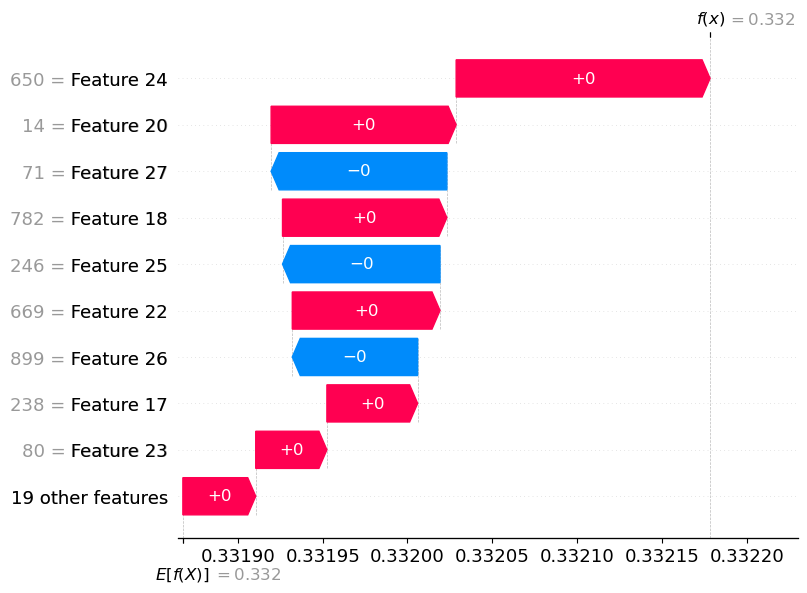

Waterfall - neutral


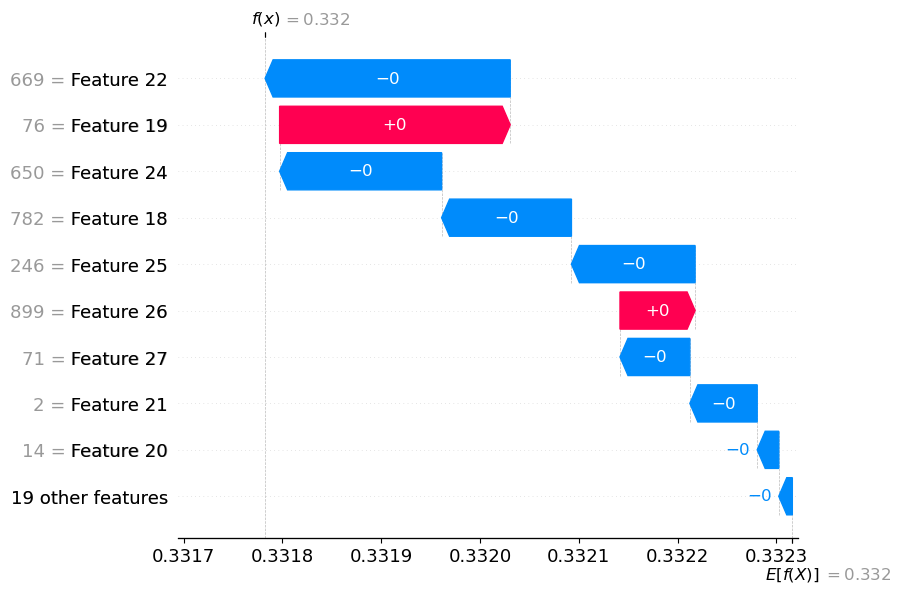

Waterfall - positive


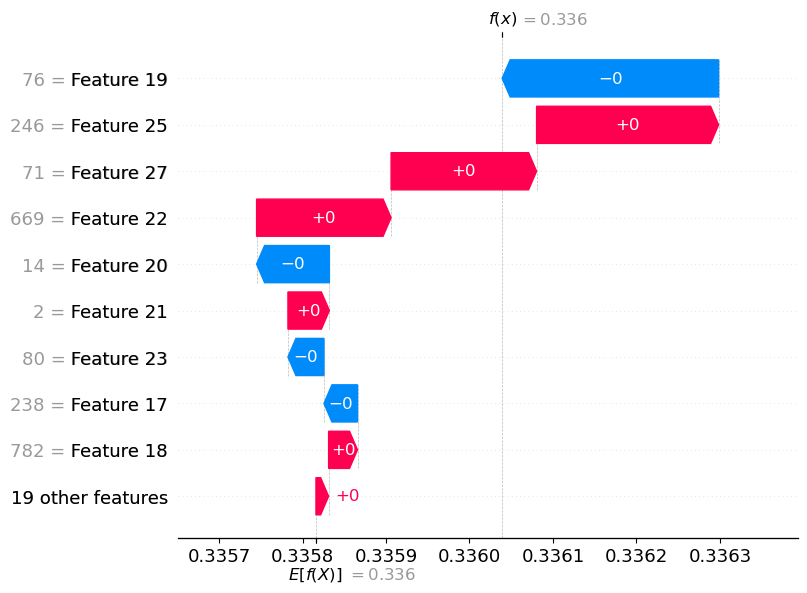

In [122]:
print(shap_values.shape)

print("Waterfall - negative")
shap.plots.waterfall(shap_values[0,:,0])
print("Waterfall - neutral")
shap.plots.waterfall(shap_values[0,:,1])
print("Waterfall - positive")
shap.plots.waterfall(shap_values[0,:,2])

Beeswarm - negative


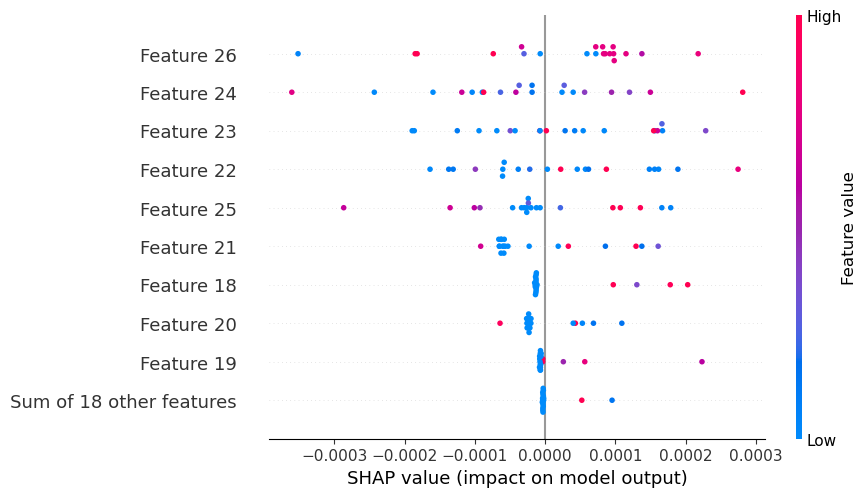

Beeswarm - neutral


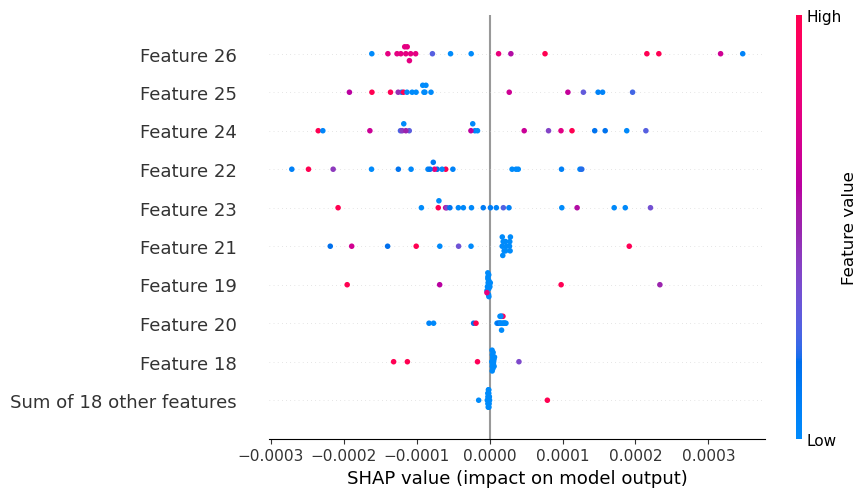

Beeswarm - positive


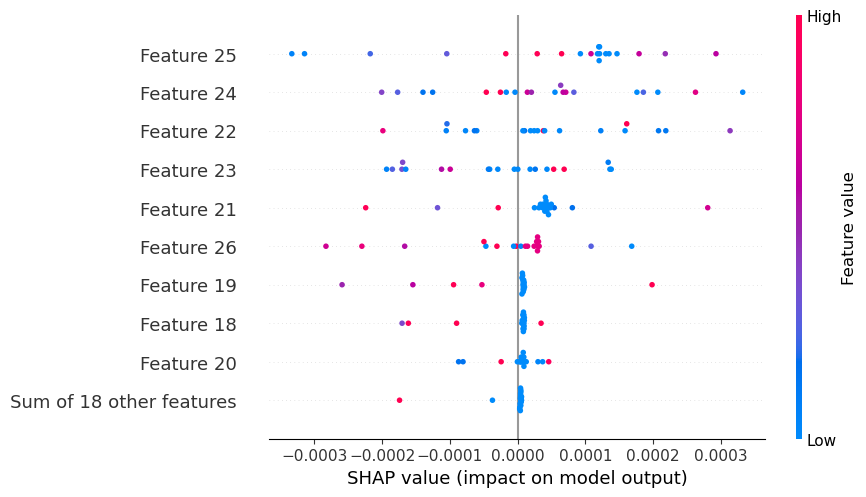

In [123]:
print("Beeswarm - negative")
shap.plots.beeswarm(shap_values[:,:-1,0])
print("Beeswarm - neutral")
shap.plots.beeswarm(shap_values[:,:-1,1])
print("Beeswarm - positive")
shap.plots.beeswarm(shap_values[:,:-1,2])

# Not working

## NLP Model

In [80]:
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from transformers.modeling_outputs import SequenceClassifierOutput

vocab_size = 3000
embedding_dim = 1500
num_classes = 3
tokenizer = Tokenizer(num_words = vocab_size, split=' ')
tokenizer.fit_on_texts(data['text'].values)
train_tokens = tokenizer.texts_to_sequences(data['text'].values)
train_tokens = pad_sequences(train_tokens)

#get attention mask
attention_mask = np.where(train_tokens != 0, 1, 0)
attention_mask = torch.tensor(attention_mask, dtype=torch.long)

# # print token and corresponding word
# word_index = tokenizer.word_index
# for word, index in word_index.items():
#     print(f"{word} => {index}")
#     if index == 12:
#         break
# # print sentences dataSentiment['text'] and corresponding token
# for i in range(5):
#     print(f"Sentence: {data['text'][i]}")
#     print(f"Token: {train_tokens[i]}")

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, dtype=torch.float32)
        self.lstm = nn.LSTM(embedding_dim, 64, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        return x.softmax(dim=1)

# # Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print("Device:", device)

model = TextClassificationModel(vocab_size, embedding_dim, num_classes).to(device)

# Przygotowanie danych do modelu
X = train_tokens[:]
y = data['sentiment']

X = np.array(X)
y = np.array(y)

# Zakodowanie etykiet tekstowych na numeryczne
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


num_classes = len(set(y_encoded))
print(set(y_encoded))
print("Number of classes:", num_classes)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# get attention mask for train and test data
attention_mask_train = attention_mask[X_train]
attention_mask_test = attention_mask[X_test]


# Przygotowanie danych do modelu
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# get attention mask for train and test data


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
trainAttentionMask = TensorDataset(X_train, attention_mask_train, y_train)
testAttentionMask = TensorDataset(X_test, attention_mask_test, y_test)

# data loader for attention mask


# train_loader = DataLoader(train_dataset, batch_size=2,) #sampler= sampler) # True
# test_loader = DataLoader(test_dataset, batch_size=2,) #sampler= sampler)

print("X_train_tensor shape:", X_train.shape)
print("y_train_tensor shape:", y_train.shape)

# Calculate class weights
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

# Print class counts and weights (optional)
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

sampler = WeightedRandomSampler(weights= sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=128,) #sampler= sampler) # True
test_loader = DataLoader(test_dataset, batch_size=128,) #sampler= sampler)

# DataLoader for attention mask
train_loader_attention_mask = DataLoader(trainAttentionMask, batch_size=32,) #sampler= sampler) # True
test_loader_attention_mask = DataLoader(testAttentionMask, batch_size=32,) #sampler= sampler)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(next(iter(test_loader))[0])

def train(dataloader, model, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    total_acc = 0
    total_count = 0
    log_interval = 1000

    for i, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_loss += loss.item()
        total_acc += (output.argmax(1) == targets).sum().item()
        total_count += targets.size(0)

    return total_loss / len(dataloader)

def evaluate(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0 # accuracy
    total_count = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)
            total_loss += loss.item() # sum of loss
            total_acc += (output.argmax(1) == targets).sum().item() #  count correct predictions
            total_count += targets.size(0)
    return total_loss / len(dataloader), total_acc / total_count

## podejście drugier, próbuje inny model wytrenować, z nim powinno być łatwiej dostać wartości shap
def train_transformers(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in iterator:
        optimizer.zero_grad()

        inputs, attention_mask, labels = batch
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(inputs, attention_mask=attention_mask, labels=labels).to(device)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(iterator)

def evaluate_transformers(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            # unzip
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(inputs, attention_mask=attention_mask, labels=labels).to(device)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(iterator)

Device: cuda
{0, 1, 2}
Number of classes: 3
X_train_tensor shape: torch.Size([54706, 36])
y_train_tensor shape: torch.Size([54706])
Class Counts: [12010 18374 24322]
Class Weights: [8.32639467e-05 5.44247306e-05 4.11150399e-05]
tensor([[   0,    0,    0,  ...,  111, 1498,  816],
        [   0,    0,    0,  ...,   22,    1,  116],
        [   0,    0,    0,  ...,    5,  380, 2186],
        ...,
        [   0,    0,    0,  ..., 1534,  120,  620],
        [   0,    0,    0,  ...,  199,    1,  658],
        [   0,    0,    0,  ..., 1189,    9,    2]])


In [18]:
#test - trenowanie modelu z transformers, na ppierwszym nie działa analiza shap
epochs = 20
# train model and save loss for plotting
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)


train_loss = []
test_loss = []
train_acc = []
test_acc = []
torch.set_grad_enabled(True)

for epoch in range(epochs):
    train_loss.append(train_transformers(model, train_loader_attention_mask, optimizer, criterion, device))
    test_loss.append(evaluate_transformers(model, test_loader_attention_mask, criterion, device))
    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss[-1]:.4f}")
    print(f"Test Loss: {test_loss[-1]:.4f}")
    print()

# save model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: shape '[32, 1, 1, 36]' is invalid for input of size 41472

In [19]:
epochs = 15
# train model and save loss for plotting

train_loss = []
test_loss = []
train_acc = []
test_acc = []
torch.set_grad_enabled(True)

for epoch in range(1, epochs + 1):
    train_epoch_loss = train(train_loader, model, criterion, optimizer, epoch)
    test_epoch_loss, accuracy = evaluate(test_loader, model, criterion)

    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    test_acc.append(accuracy)

    print(f'| End of Epoch: {epoch:02} | Train Loss: {train_epoch_loss:.5f} | Test Accuracy: {accuracy:.5f}')

# save model
torch.save(model.state_dict(), 'model.pth')


AttributeError: 'SequenceClassifierOutput' object has no attribute 'argmax'

In [13]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

NameError: name 'train_loss' is not defined

<Figure size 1000x500 with 0 Axes>

## SHAP analysis

In [14]:
# load model from file,
from torch.autograd import Variable
model = TextClassificationModel(vocab_size, embedding_dim, num_classes)
model.load_state_dict(torch.load('model.pth'))
model.to(device)
torch.set_grad_enabled(False)
# device = torch.device("cpu")

tokenizer = Tokenizer(num_words = vocab_size, split=' ')

readTrump = pd.read_csv('realdonaldtrump.csv')

# Ustawienie wszystkich liter na małe
readTrump['content'] = readTrump['content'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
readTrump['content'] = readTrump['content'].apply(lambda x : remove_url(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_ment(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_punct(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
readTrump['content'] = readTrump['content'].apply(lambda x : unique_char(cont_rep_char,x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_stopwords(x))

# Usunięcie duplikatów
readTrump = readTrump.drop_duplicates(subset=['content'])

# Usunięcie pustych wartości
readTrump = readTrump.dropna(subset=['content'])
readTrump.drop(["id","link","date","retweets","favorites","mentions","hashtags"], axis=1, inplace=True)

readTrump.to_csv('clearTrump.csv', index=False)
tokenizer.fit_on_texts(data['text'].values)
train_tokens = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(train_tokens)
X = torch.tensor(X, dtype=torch.long).to(device).requires_grad_(False).to(torch.long)

background = X[:100]

expl = shap.DeepExplainer(model, background)
shap_values = expl.shap_values(X)

# # Utworzenie DataLoader
# data_loader = DataLoader(X, batch_size=64)

# f = lambda x: model( Variable( torch.from_numpy(x) ) ).detach().numpy()

# # Pobranie batcha danych
# batch = next(iter(data_loader))
# trumpdata = batch

# # Przygotowanie tła dla SHAP
# background = trumpdata[:100]
# background = background.requires_grad_(False).to(torch.long)

# # Ustawienie SHAP
# explainer = shap.DeepExplainer(f, background)

# # Obliczanie wartości SHAP
# shap_values = explainer.shap_values(X[:1000])

NameError: name '_C' is not defined